### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

 ### 2 Reading Data

In [3]:
%%time
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('data/cleaned_data.csv')

CPU times: user 253 ms, sys: 63.3 ms, total: 317 ms
Wall time: 314 ms


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# Creating database path
database_dir = '/home/notebooks/'
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebook/' location
def create_sqlit_connection(db_path,db_file):
    """ 
    Description - create a database connection to a SQLite database 
    Input = database path , database file
    output = None
    """
    conn = None
    # creating a connection the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version) # print the version of sqlite
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
            
# Creating connection to database
create_sqlit_connection(database_dir, "lead_scoring_model_experimentation.db")

2.6.0


In [7]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"
mlflow.set_tracking_uri("http://0.0.0.0:6007")

In [8]:
# setup pycaret 
Baseline_model_exp_01 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp_01',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2022/11/02 13:14:49 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_model_exp_01' does not exist. Creating a new experiment.


### 4 : Model Experimentation with pycaret

In [9]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8317,0.7029,0.7619,0.4766,0.4849,0.6780
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8343,0.7020,0.7624,0.4765,0.4854,4.5920
et,Extra Trees Classifier,0.7367,0.8176,0.8210,0.7044,0.7582,0.4729,0.4797,3.9880
dt,Decision Tree Classifier,0.7364,0.8166,0.8205,0.7041,0.7579,0.4723,0.4789,0.5680
rf,Random Forest Classifier,0.7346,0.8169,0.8394,0.6957,0.7608,0.4686,0.4791,1.5160
lr,Logistic Regression,0.7098,0.7836,0.8220,0.6731,0.7402,0.4189,0.4297,1.5420
ridge,Ridge Classifier,0.7005,0.0000,0.7962,0.6702,0.7278,0.4003,0.4077,0.2720
lda,Linear Discriminant Analysis,0.7005,0.7733,0.7961,0.6702,0.7277,0.4003,0.4077,0.9780
nb,Naive Bayes,0.6629,0.7335,0.8924,0.6134,0.7269,0.3241,0.3653,0.2060


In [10]:
# create a model which gives the highest accuracy
lbgm  = create_model('lightgbm', fold = 5) 

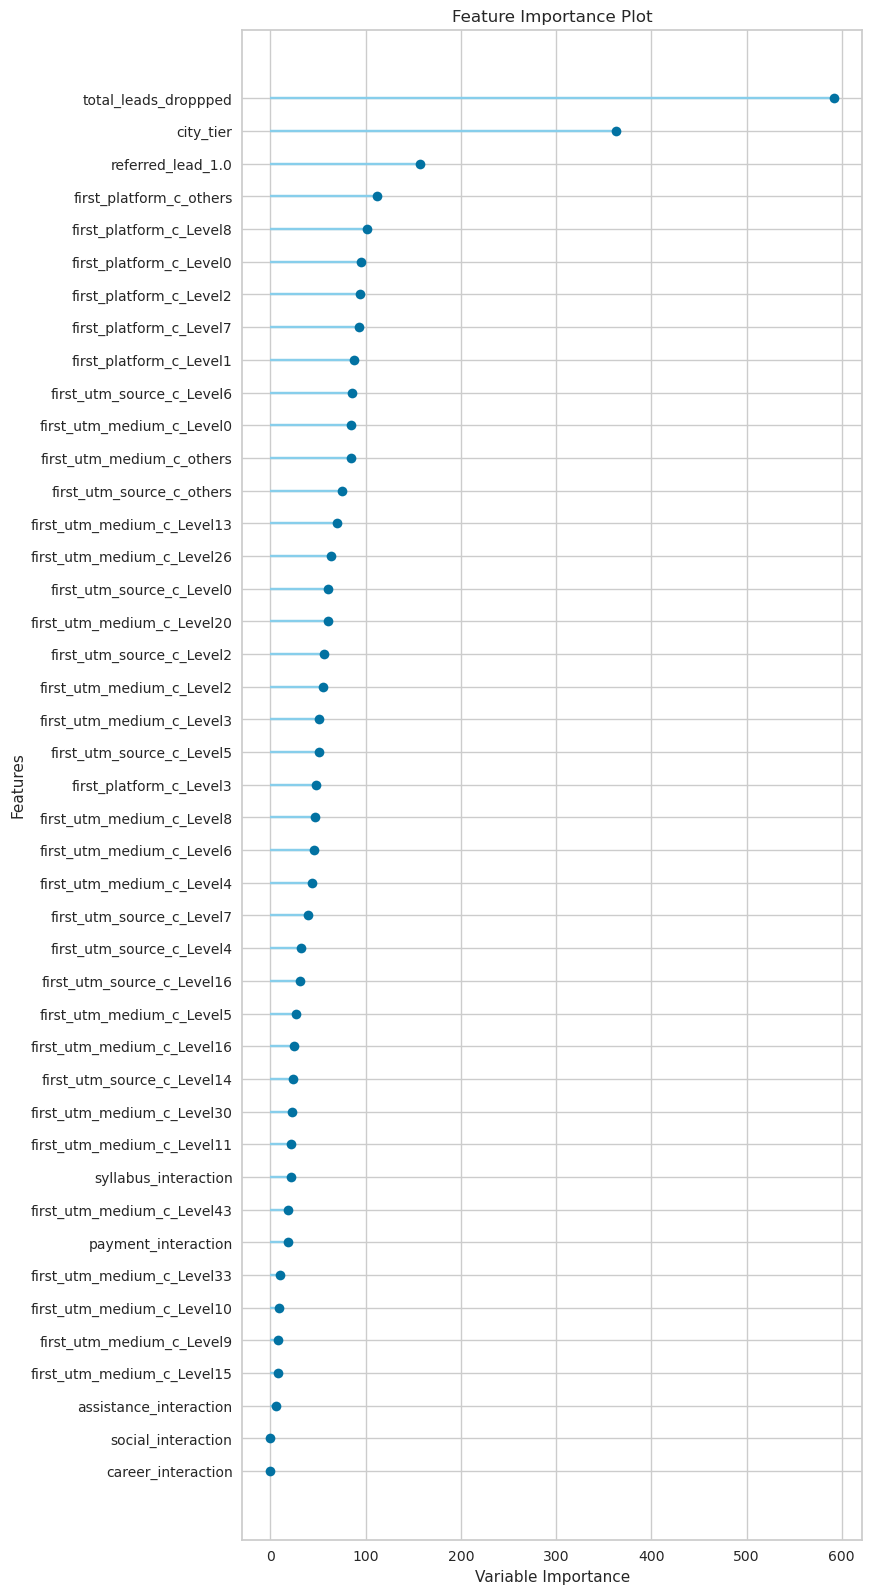

In [11]:
# create feature importance plot
plot_model(lbgm, plot='feature_all')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [12]:
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
final_dataset = dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]

# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
Baseline_model_exp_02 = setup(data = final_dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp_02',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False,
                   normalize = False ,  transformation = False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2022/11/02 13:25:42 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_model_exp_02' does not exist. Creating a new experiment.


In [13]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8210,0.8348,0.7018,0.7625,0.4765,0.4855,4.3160
xgboost,Extreme Gradient Boosting,0.7384,0.8209,0.8303,0.7031,0.7614,0.4762,0.4843,0.5780
et,Extra Trees Classifier,0.7366,0.8174,0.8211,0.7042,0.7582,0.4727,0.4795,3.6180
dt,Decision Tree Classifier,0.7363,0.8166,0.8205,0.7041,0.7578,0.4722,0.4788,0.5320
rf,Random Forest Classifier,0.7350,0.8178,0.8432,0.6949,0.7619,0.4693,0.4805,1.3320
lr,Logistic Regression,0.7098,0.7836,0.8222,0.6730,0.7402,0.4188,0.4296,0.2020
ridge,Ridge Classifier,0.7002,0.0000,0.7959,0.6700,0.7275,0.3998,0.4072,0.1700
lda,Linear Discriminant Analysis,0.7002,0.7726,0.7959,0.6700,0.7275,0.3998,0.4072,0.8520
nb,Naive Bayes,0.6701,0.7337,0.8568,0.6255,0.7231,0.3387,0.3650,0.1920


In [14]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lbgm  = create_model('lightgbm', fold = 5)

In [15]:
!pip install optuna

     |████████████████████████████████| 348 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 41.6 MB 164 kB/s  eta 0:00:01
     |████████████████████████████████| 50 kB 9.3 MB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 36.5 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 64.1 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=8b07cc96ad85f2a9e0e5cfbceeaa921572356ee3d7183d1ba99b015a0f3225e4
  Stored in directory: /home/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled scipy-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follo

In [16]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
tuned_lgbm_optuna,tuner = tune_model(lbgm, 
                                    search_library='optuna',
                                    search_algorithm='random',
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True)

In [17]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuner)
print("**"*30)
print(tuned_lgbm_optuna)

OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=None,
                                  steps=[('empty_step', 'passthrough'),
                                         ('actual_estimator',
                                          LGBMClassifier(boosting_type='gbdt',
                                                         class_weight=None,
                                                         colsample_bytree=1.0,
                                                         device='gpu',
                                                         importance_type='split',
                                                         learning_rate=0....
                                    'actual_estimator__reg_alpha': FloatDistribution(high=10.0, log=True, low=1e-10, step=None),
                                    'actual_estimator__